In [355]:
#imports
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
#from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math


In [356]:
ticker_symbol = 'Data/ADANIENT.NS.csv'
test_days = 40

In [357]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
stock_data = pd.read_csv(ticker_symbol,sep=',', index_col='Date', parse_dates=['Date'], date_parser=dateparse).fillna(0)
stock_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-05-02,90.051537,90.789398,79.689354,83.025780,81.824608,13025322
2018-05-03,83.410751,83.731567,79.111893,81.100922,79.927597,20057125
2018-05-04,81.293404,84.982727,80.619705,81.229240,80.054062,20059687
2018-05-07,81.550056,83.346596,80.106407,81.870865,80.686401,19006661
2018-05-08,82.287918,85.656425,80.715942,84.341103,83.120903,7209269
...,...,...,...,...,...,...
2023-04-24,1804.000000,1817.400024,1775.800049,1801.949951,1801.949951,1963582
2023-04-25,1806.000000,1913.750000,1801.800049,1844.599976,1844.599976,5364841
2023-04-26,1854.000000,1874.000000,1826.400024,1847.900024,1847.900024,2422711


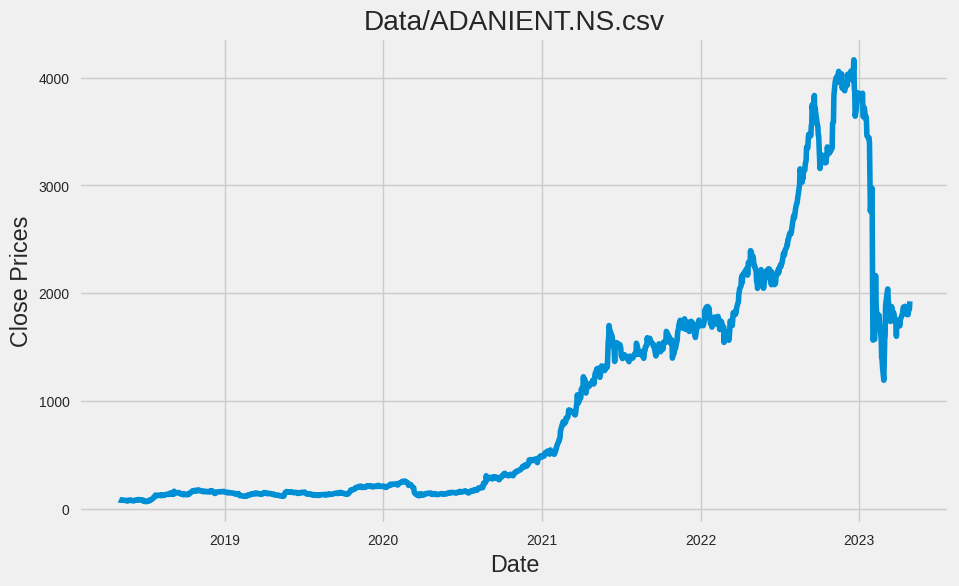

In [358]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(stock_data['Close'])
plt.title(ticker_symbol)
plt.show()

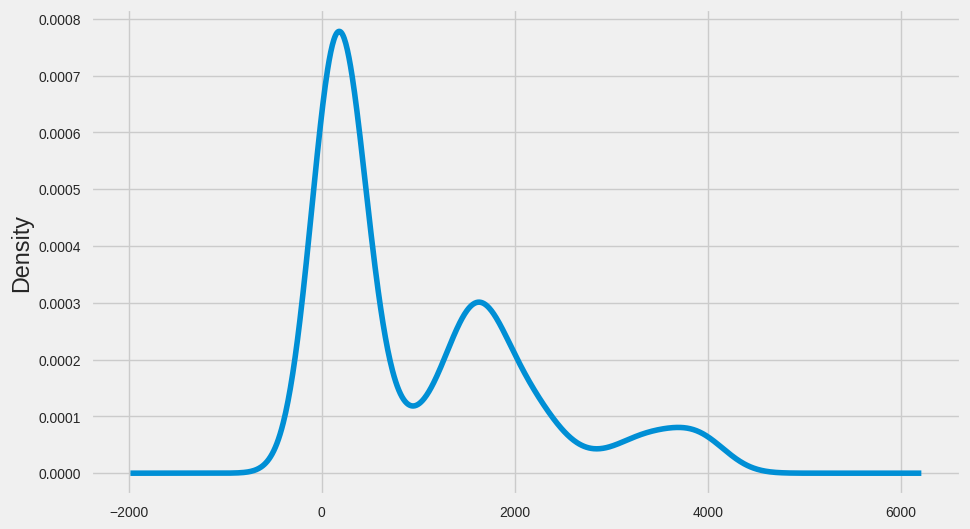

In [359]:
#Distribution of the dataset
stock_data['Close'].plot(kind='kde')
df_close = stock_data['Close']

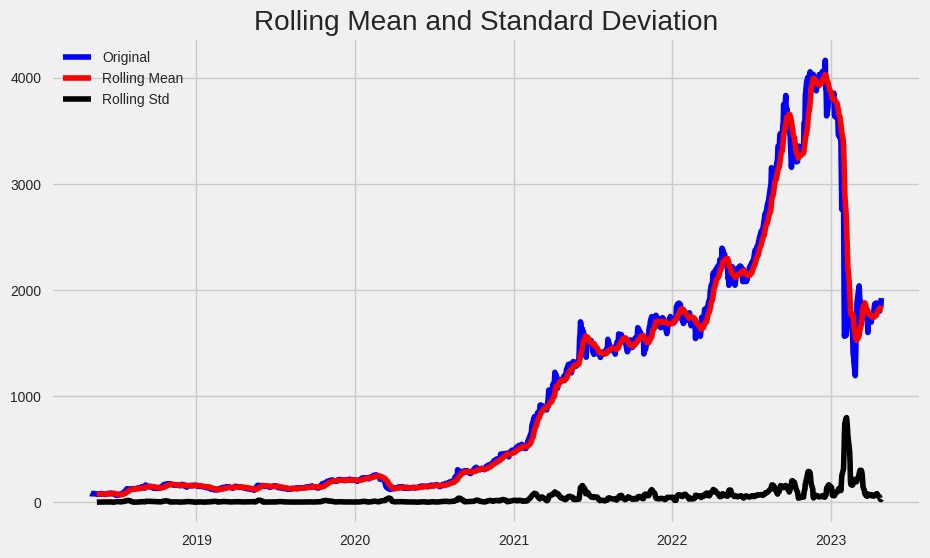

Results of dickey fuller test
Test Statistics                  -1.058202
p-value                           0.731449
No. of lags used                 23.000000
Number of observations used    1210.000000
critical value (1%)              -3.435766
critical value (5%)              -2.863932
critical value (10%)             -2.568043
dtype: float64


In [360]:
#testing for stationarity
#This test can be theoretical used wonderfully for mean reversion

#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(df_close)

<Figure size 1000x600 with 0 Axes>

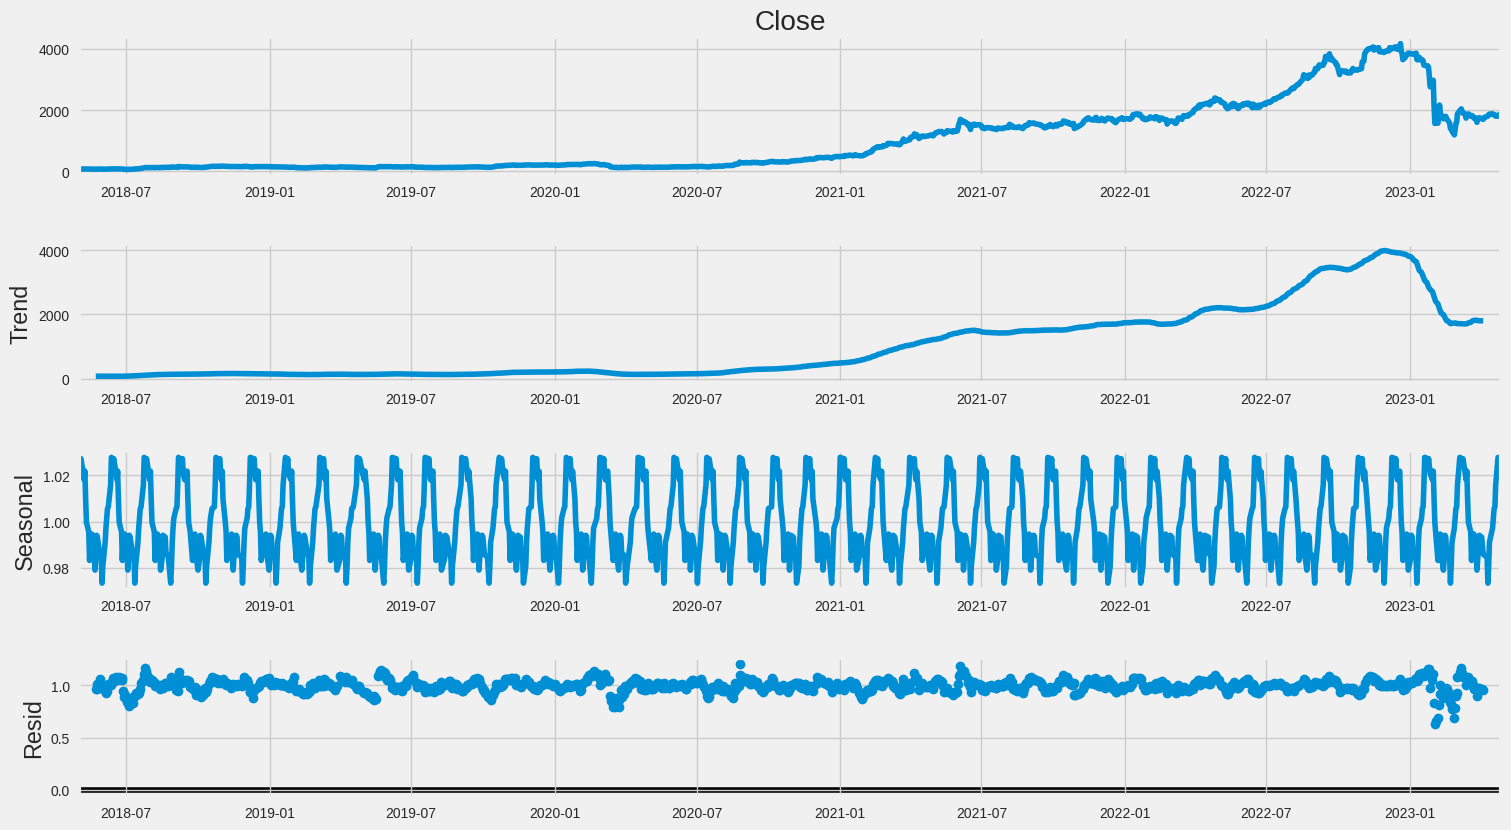

In [361]:
#since it is not stationary, we remove the seasonal part
#To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
result = seasonal_decompose(df_close, model='multiplicative', period = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


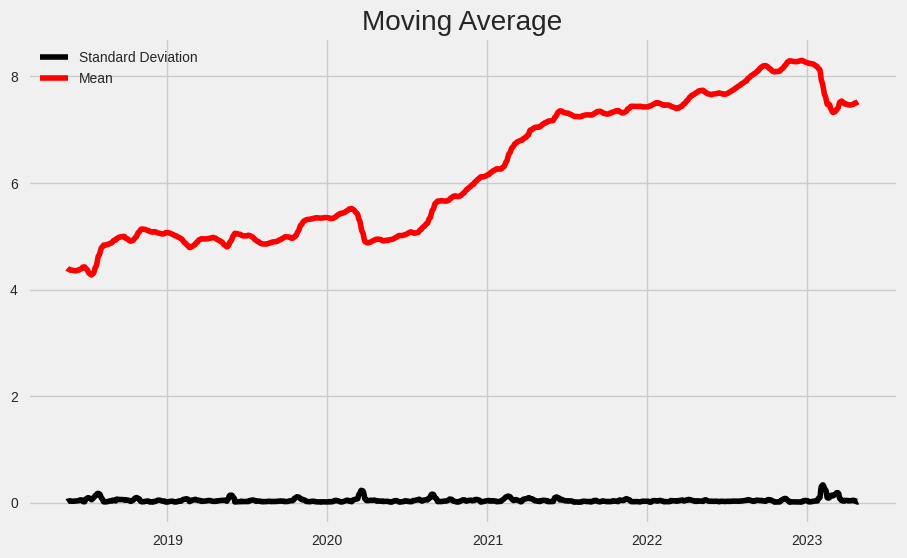

In [362]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

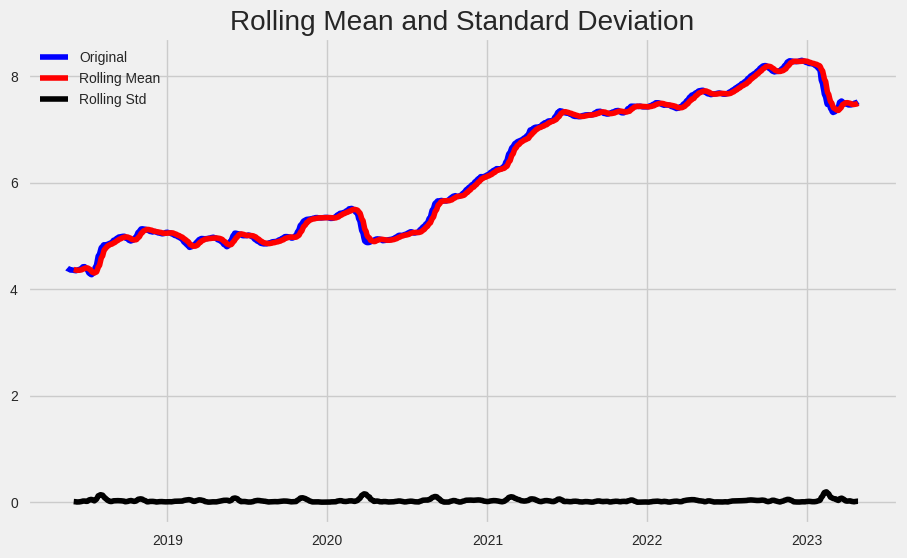

Results of dickey fuller test
Test Statistics                  -1.106152
p-value                           0.712612
No. of lags used                 18.000000
Number of observations used    1204.000000
critical value (1%)              -3.435793
critical value (5%)              -2.863944
critical value (10%)             -2.568050
dtype: float64


In [363]:
# Replacing infinite with nan
moving_avg.replace([np.inf, -np.inf], np.nan, inplace=True)
  
# Dropping all the rows with nan values
moving_avg.dropna(inplace=True)
#testing the stationarity again
test_stationarity(moving_avg)

Now comes the actual training

In [364]:
t = len(df_log) - test_days

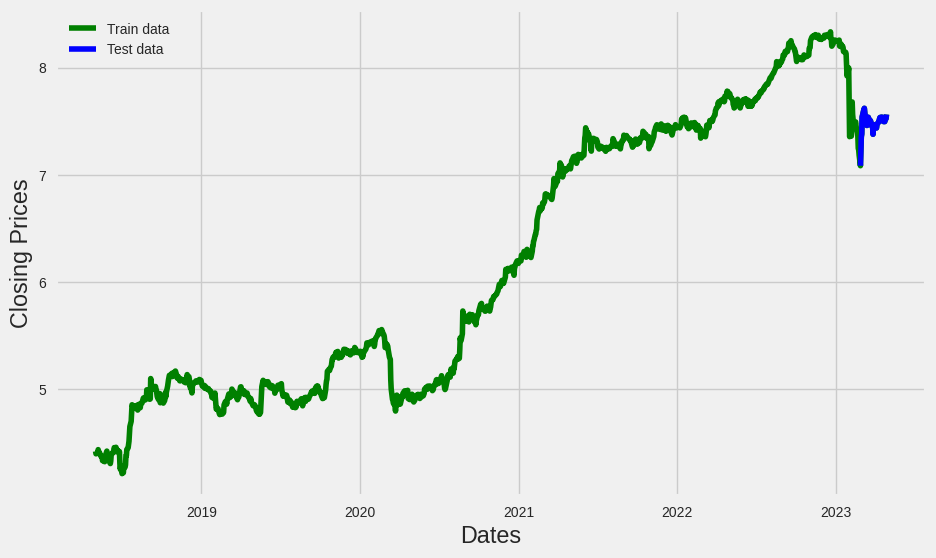

In [365]:
train_data, test_data = df_log[3:t], df_log[t:]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4602.086, Time=0.32 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4608.049, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4608.034, Time=0.81 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4598.788, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-4606.050, Time=0.38 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4606.057, Time=0.27 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-4604.049, Time=1.15 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-4605.577, Time=0.11 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 3.638 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1191
Model:               SARIMAX(1, 1, 0)   Log Likelihood                2307.025
Date:                Mon, 01 May 2023   AIC                          -4608.049
Time:                       

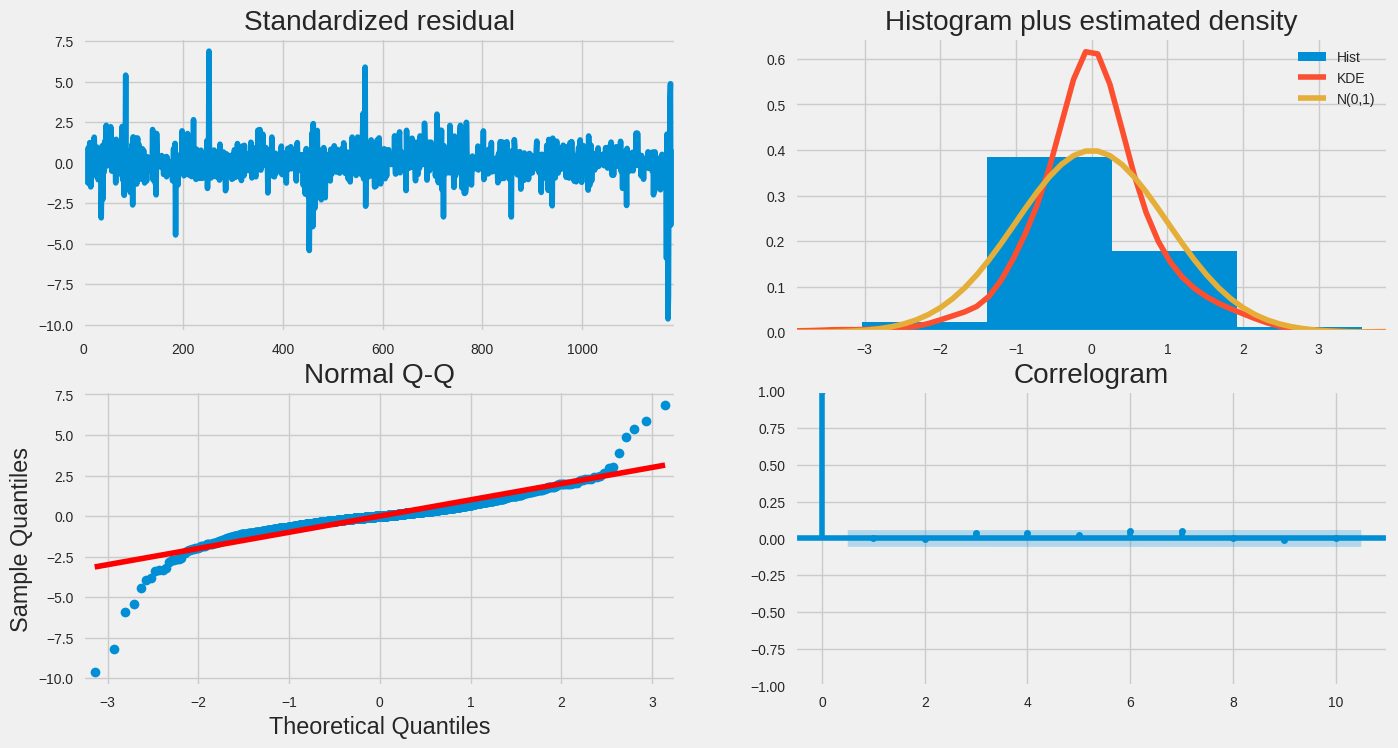

In [366]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [367]:
#from statsmodels.tsa import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

In [368]:
#Modeling
# Build Model
model = ARIMA(train_data, order=(1,1,2))  
fitted = model.fit()  
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1191
Model:                 ARIMA(1, 1, 2)   Log Likelihood                2310.474
Date:                Mon, 01 May 2023   AIC                          -4612.948
Time:                        02:13:15   BIC                          -4592.621
Sample:                             0   HQIC                         -4605.288
                               - 1191                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9815      0.018     55.068      0.000       0.947       1.016
ma.L1         -0.9042      0.021    -42.123      0.000      -0.946      -0.862
ma.L2         -0.0528      0.013     -4.131      0.0

In [369]:
# Forecast
#fc, se, conf = fitted.forecast(321, alpha=0.05)  # 95% conf
forecast = fitted.get_forecast(test_data.shape[0], alpha=0.05)  # 95% conf

In [370]:
fc = forecast.predicted_mean
se = forecast.se_mean
conf = forecast.conf_int(alpha=0.05)

In [371]:
#fc.rename(index=test_data.index)
fc_series_temp = np.exp(fc.to_numpy())
lower_series_temp = np.exp(conf.iloc[:,0].to_numpy())
upper_series_temp = np.exp(conf.iloc[:,1].to_numpy())

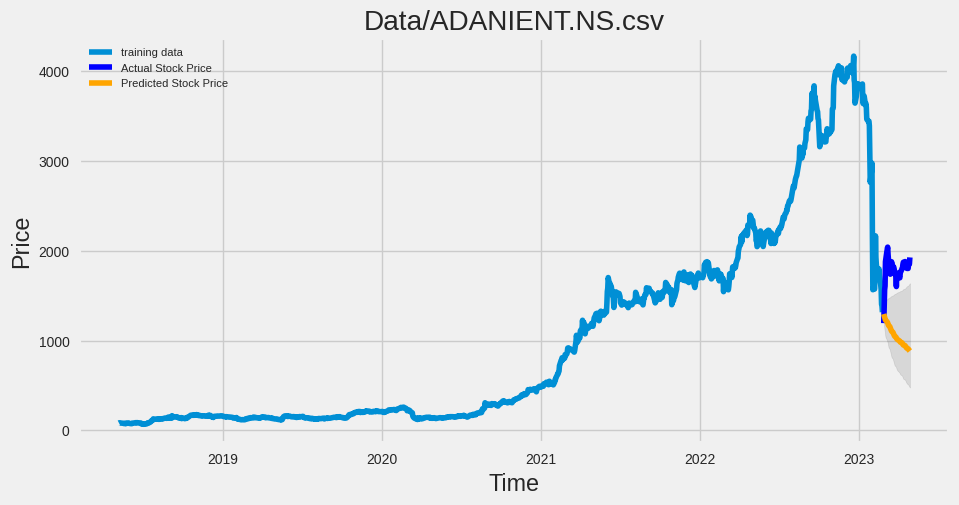

In [372]:
#indexing
test_indexing = test_data.index
train_indexing = train_data.index

# Make as pandas series
fc_series = pd.Series(fc_series_temp, index=test_indexing)
lower_series = pd.Series(lower_series_temp, index=test_indexing)
upper_series = pd.Series(upper_series_temp, index=test_indexing)

#scale test_data
test_data = pd.Series(np.exp(test_data.to_numpy()), index = test_indexing)
train_data = pd.Series(np.exp(train_data.to_numpy()), index=train_indexing)


# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.title(ticker_symbol)
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()